# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [13]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data.head(20)

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
5,Drake,"Ayy, yeah I got one, Laurie got one and that t..."
6,Drake,"Well, summer, all I did was rest, okay? And Ne..."
7,Drake,I'm makin' a change today The liquor been taki...
8,Drake,(Six) Yeah Yeah Yeah
9,Drake,"Leave me out the comments, leave me out the no..."


In [56]:
data.describe

<bound method NDFrame.describe of           artist                                              verse  \
0          Drake                            Ayy, woah Ayy, ayy Yeah   
1          Drake  I'm makin' a change today The liquor been taki...   
2          Drake  I can't just be with you and only you Yeah, I ...   
3          Drake  Well, summer, all I did was rest, okay? And Ne...   
4          Drake  I'm makin' a change today The liquor been taki...   
...          ...                                                ...   
3970  Kanye West  Dame was like, "Yo you got a deal with Capitol...   
3971  Kanye West  Then one day I just went ahead and played it, ...   
3972  Kanye West             "I ain't gonna front, it's kinda hot."   
3973  Kanye West  Like they still weren't looking at me like a r...   
3974  Kanye West  "You gotta be under an umbrella, you'll get ra...   

                                            clean_verse  
0                               Ayy, woah Ayy, ayy Yeah

❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [18]:
data[18:19].values

array([['Drake',
        'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah']],
      dtype=object)

In [51]:
from unidecode import unidecode

data['clean_verse'] = data['verse'].apply(unidecode)


In [53]:
data.head()

,artist,verse,clean_verse
0,Drake,"Ayy, woah Ayy, ayy Yeah","Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ...","I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [32]:
duplicate_in_verse = data.duplicated(subset=['verse'])
duplicate_in_verse.value_counts()

False    3039
True      936
dtype: int64

In [33]:
data = data.drop_duplicates() # Remove duplicates

In [35]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [36]:
data.artist.value_counts()

Drake         1394
Ed Sheeran     867
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [37]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [38]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [39]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,my,in,me
10,that,it,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [40]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [41]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

14.92% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [59]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

data['seq'] = data['clean_verse'].apply(text_to_word_sequence)

In [60]:
data.head()

,artist,verse,clean_verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

/home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

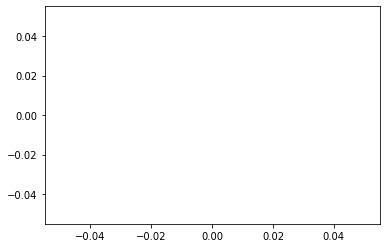

In [68]:
import seaborn as sns
sns.kdeplot(x=range(1000), y=len(data['seq']))

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [69]:
def limit_300(list):
    list = list[:300]
    return list

In [70]:
data['reduced_seq'] = data['seq'].apply(limit_300)

In [73]:
data.drop(columns='seq', inplace =True)

In [79]:
data['reduced_seq'][10:20].values

array([list(["tryin'", "tryin'", "tryin'", "tryin'", 'i', 'pray', 'these', 'niggas', 'understand', 'how', 'passionate', 'the', 'tale', 'is', 'to', 'get', 'you', 'under', 'my', 'pressure', 'richer', 'i', 'been', "tryin'", "tryin'", "tryin'", "tryin'", 'to', 'get', 'you', 'under', 'my', 'pressure', 'yes', 'uh', 'biggest', 'you', 'feel', 'me', 'm', 'm', 'm', 'maybach', 'music']),
       list(['godfather', 'with', 'a', 'garden', 'full', 'of', 'snakes', 'call', 'porsche', 'time', 'to', 'give', 'away', 'a', 'wraith', 'bricks', 'boy', 'tryna', 'turn', "'em", 'into', 'bass', 'big', 'boy', 'i', 'been', "tryin'", 'buy', 'the', 'braves', 'courtroom', "soundin'", 'like', "i'm", 'in', 'the', 'opera', 'went', 'and', 'got', 'it', 'now', 'these', 'niggas', 'wanna', 'knock', 'us', 'bitches', "fallin'", "'cause", 'they', 'need', 'a', 'couple', 'dollars', 'but', 'it', "ain't", 'a', 'problem', "'cause", 'a', 'nigga', 'really', 'got', 'it', 'fat', 'boy', 'rich', 'nigga', 'with', 'a', 'appetite', 'count', '

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [83]:
from sklearn.model_selection import train_test_split
X = data[['reduced_seq']]
y = data['artist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [84]:
from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=X_train[:1000], vector_size=100)

RuntimeError: you must first build vocabulary before training the model

In [19]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [20]:
import numpy as np

def embed_sentence(word2vec, sentence):
    
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [ ]:
def embedding(word2vec, sentences):
    
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [21]:
# YOUR CODE HERE

👉 We train/test split the dataset below for you

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [89]:
import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

In [90]:
! rm data_lyrics_solution.pickle

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [26]:
score_baseline = 0.33

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [102]:
# RNN
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.Embedding(
    input_dim=10_000,
    input_length=300,
    output_dim=100,
    mask_zero=True
))
model.add(layers.LSTM(10))
model.add(layers.Dense(1, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,004,451
Trainable params: 1,004,451
Non-trainable params: 0
_________________________________________________________________


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [103]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=2)

history = model.fit(X_train, y_train,
          validation_split=0.3,
          epochs=30, 
          batch_size=16,
          callbacks=[es]
          )

Epoch 1/30


ValueError: in user code:

    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm_9 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (16, 300, 100, 100)


❓ **Plot the training and validation losses through training**

In [104]:
# Plot below your train/val loss history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

NameError: name 'history' is not defined

❓ **Save your accuracy on test set as `score_test`**

In [105]:
score_test = model.evaluate(X_test, y_test)

ValueError: in user code:

    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/xavier/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm_9 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 300, 100, 100)


🧪 **Send your results below**

In [33]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()